Import needed stuff

In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
# Stupid funny thing
def progressBar(current, total, barLength = 20):
    percent = float(current) * 100 / total
    arrow   = '-' * int(percent/100 * barLength - 1) + '>'
    spaces  = ' ' * (barLength - len(arrow))
    sys.stdout.write('\rProgress: [%s%s] %d %%' % (arrow, spaces, percent))

Downloading data by http request

In [2]:
reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
reply.encoding = 'utf-8'

Transfer in pandas

In [3]:
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False)
for i, name in enumerate(df.columns):
    print(i, name)

0 Project Reference
1 Academic Year
2 Mobility Start Month
3 Mobility End Month
4 Mobility Duration
5 Activity (mob)
6 Field of Education
7 Participant Nationality
8 Education Level
9 Participant Gender
10 Participant Profile
11 Special Needs
12 Fewer Opportunities
13 Participant Age
14 Sending Country Code
15 Sending City
16 Sending Organization
17 Receiving Country Code
18 Receiving City
19 Receiving Organization
20 Participants


## Mobility network
Simply focused on the number of the excange

In [14]:
mobility_df = df[df[df.columns[10]]=='Learner']
mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20))]]
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)
mobility_df

,Sending Organization,Receiving Organization,Participants,SendId,RecId
0,ADAMASTOR - ASSOCIACAO CULTURAL,Stowarzyszenie Jeden Swiat,1,48301,55179
1,ADAMASTOR - ASSOCIACAO CULTURAL,Stowarzyszenie Jeden Swiat,1,48301,55179
53,Landesberufsschule Arnfels,Language Xchange Ireland,1,11913,84653
54,Landesberufsschule Arnfels,Language Xchange Ireland,1,11913,84653
55,Landesberufsschule Arnfels,Language Xchange Ireland,1,11913,84653
...,...,...,...,...,...
688505,Asociación para la integración y Progreso de l...,The National Trust for Places of Historic Inte...,1,35105,18749
688506,COORDINADORA D'ORGANITZADORS DE CAMPS DE TREBA...,VOLUNTEER ACTION FOR PEACE,1,71703,23354
688507,INEX - SDRUZENI DOBROVOLNYCH AKTIVIT Z S,VOLUNTEER ACTION FOR PEACE,1,22386,23354
688508,SOLIDARITES JEUNESSES MCP,VOLUNTEER ACTION FOR PEACE,1,28007,23354


In [18]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

### Degree distribution

In [21]:
from collections import Counter
import matplotlib.pyplot as plt

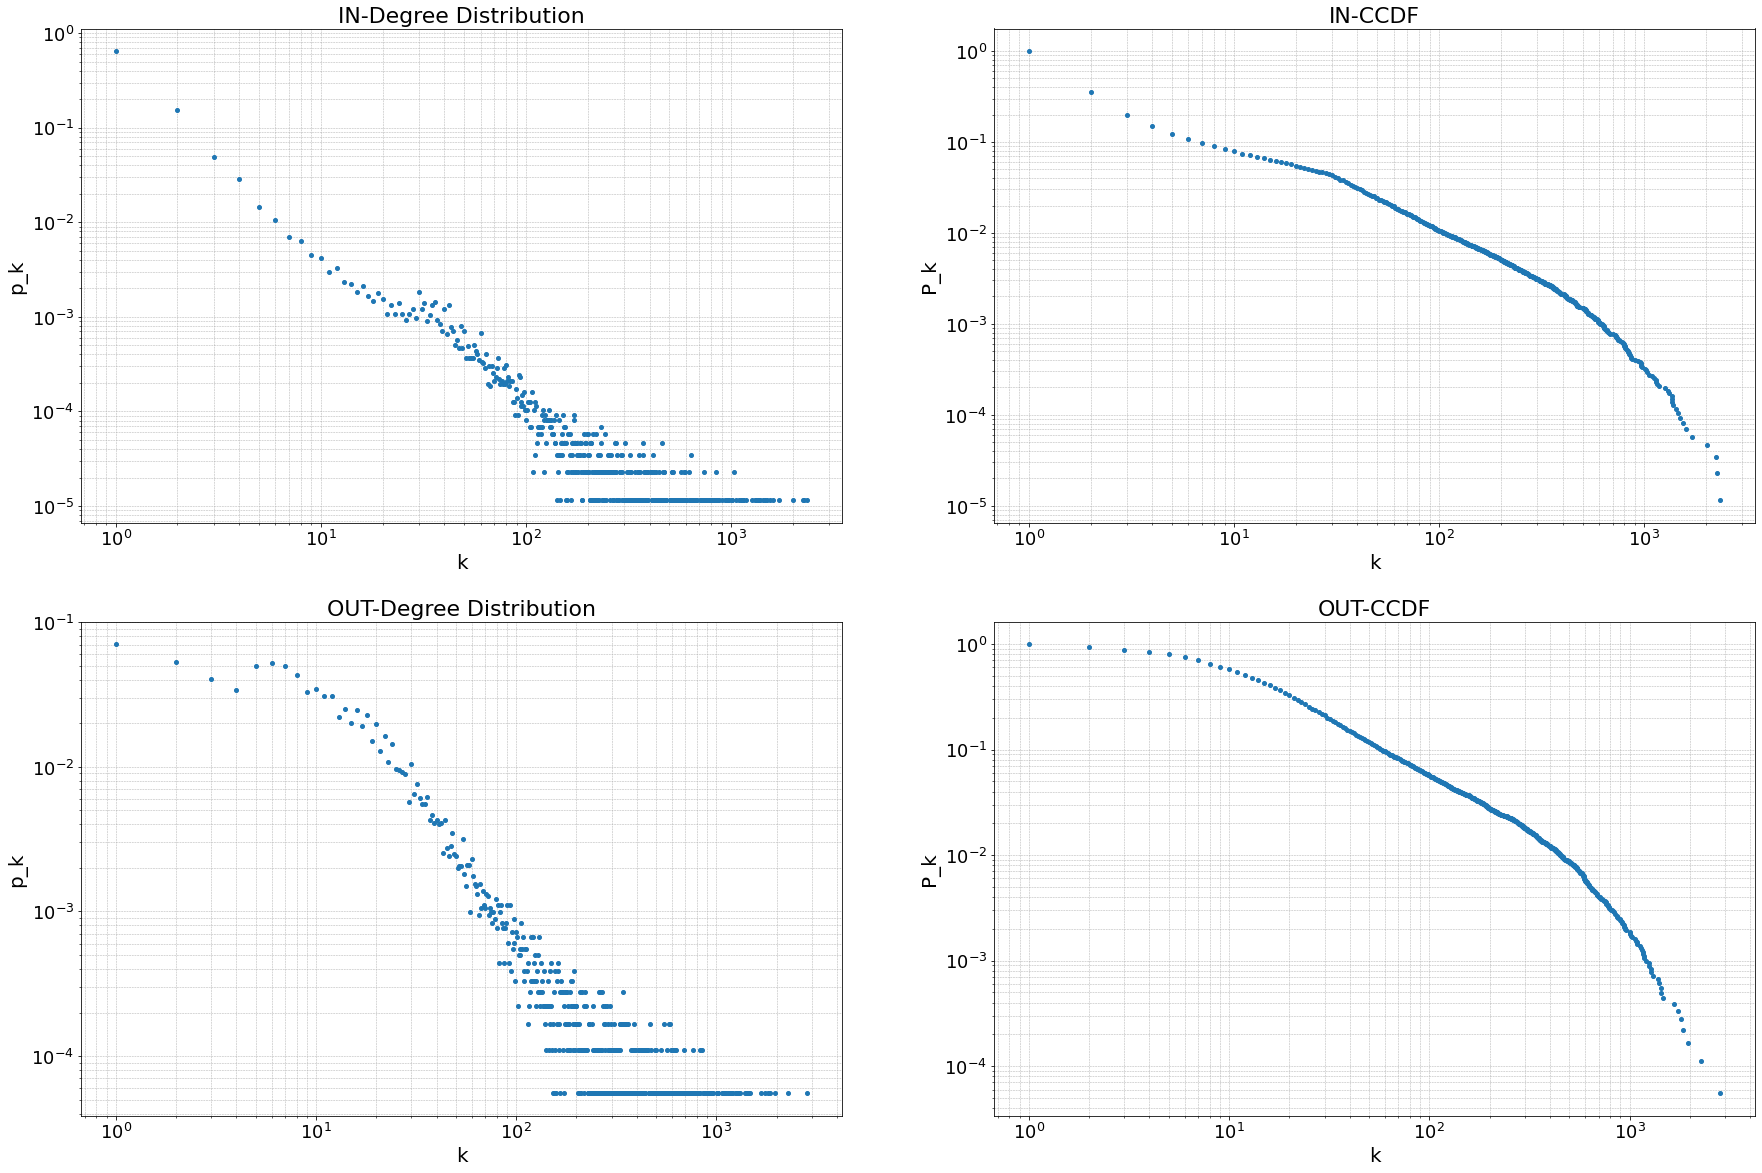

In [22]:
N = nodes.size

d_in = adj_matrix_crs.dot(np.ones(N)) 
d_in = d_in[d_in > 0]
d_out = (adj_matrix_crs.T).dot(np.ones(N))
d_out = d_out[d_out > 0]

############# in #############
sorted_d = sorted(d_in)
occurrence = Counter(sorted_d)
x_in = list(occurrence.keys())
y_in = list(occurrence.values())
y_in = y_in/np.sum(y_in)

Pk_in = 1 - np.cumsum(y_in) # complementary cumulative

# set the last value of Pk (that is equal to 0 
# and generates problems when plotting in the log-scale) 
# equal to 1 and sort Pk in decreasing order to put 
# the 1 at the beginning of the array
Pk_in[-1] = 1 
Pk_in = sorted(Pk_in, reverse = True)


############# out #############
sorted_d = sorted(d_out)
occurrence = Counter(sorted_d)
x_out = list(occurrence.keys())
y_out = list(occurrence.values())
y_out = y_out/np.sum(y_out)

Pk_out = 1 - np.cumsum(y_out) # complementary cumulative

# set the last value of Pk (that is equal to 0 
# and generates problems when plotting in the log-scale) 
# equal to 1 and sort Pk in decreasing order to put 
# the 1 at the beginning of the array
Pk_out[-1] = 1 
Pk_out = sorted(Pk_out, reverse = True)

fig, axs = plt.subplots(2, 2, figsize = (30, 20))

axs[0, 0].loglog(x_in, y_in, 'o', markersize = 4)
axs[0, 0].grid(which='both', linestyle='--', linewidth=0.5)
axs[0, 0].set_title("IN-Degree Distribution", size = 22)
axs[0, 0].set_xlabel("k", size = 20)
axs[0, 0].set_ylabel("p_k", size = 20)
axs[0, 0].tick_params(labelsize=18)
axs[0, 0].tick_params(labelsize=18)

axs[0, 1].loglog(x_in, Pk_in, 'o', markersize = 4)
axs[0, 1].grid(which='both', linestyle='--', linewidth=0.5)
axs[0, 1].set_title("IN-CCDF", size = 22)
axs[0, 1].set_xlabel("k", size = 20)
axs[0, 1].set_ylabel("P_k", size = 20)
axs[0, 1].tick_params(labelsize=18)
axs[0, 1].tick_params(labelsize=18)


axs[1, 0].loglog(x_out, y_out, 'o', markersize = 4)
axs[1, 0].grid(which='both', linestyle='--', linewidth=0.5)
axs[1, 0].set_title("OUT-Degree Distribution", size = 22)
axs[1, 0].set_xlabel("k", size = 20)
axs[1, 0].set_ylabel("p_k", size = 20)
axs[1, 0].tick_params(labelsize=18)
axs[1, 0].tick_params(labelsize=18)


axs[1, 1].loglog(x_out, Pk_out, 'o', markersize = 4)
axs[1, 1].grid(which='both', linestyle='--', linewidth=0.5)
axs[1, 1].set_title("OUT-CCDF", size = 22)
axs[1, 1].set_xlabel("k", size = 20)
axs[1, 1].set_ylabel("P_k", size = 20)
axs[1, 1].tick_params(labelsize=18)
axs[1, 1].tick_params(labelsize=18)

plt.show()

### HITS (NetworkX)

In [23]:
import networkx as nx

In [24]:
hh, aa = nx.algorithms.link_analysis.hits_alg.hits(nx.DiGraph(adj_matrix_crs.T), tol = 1e-4/len(nx.DiGraph(adj_matrix_crs.T)))

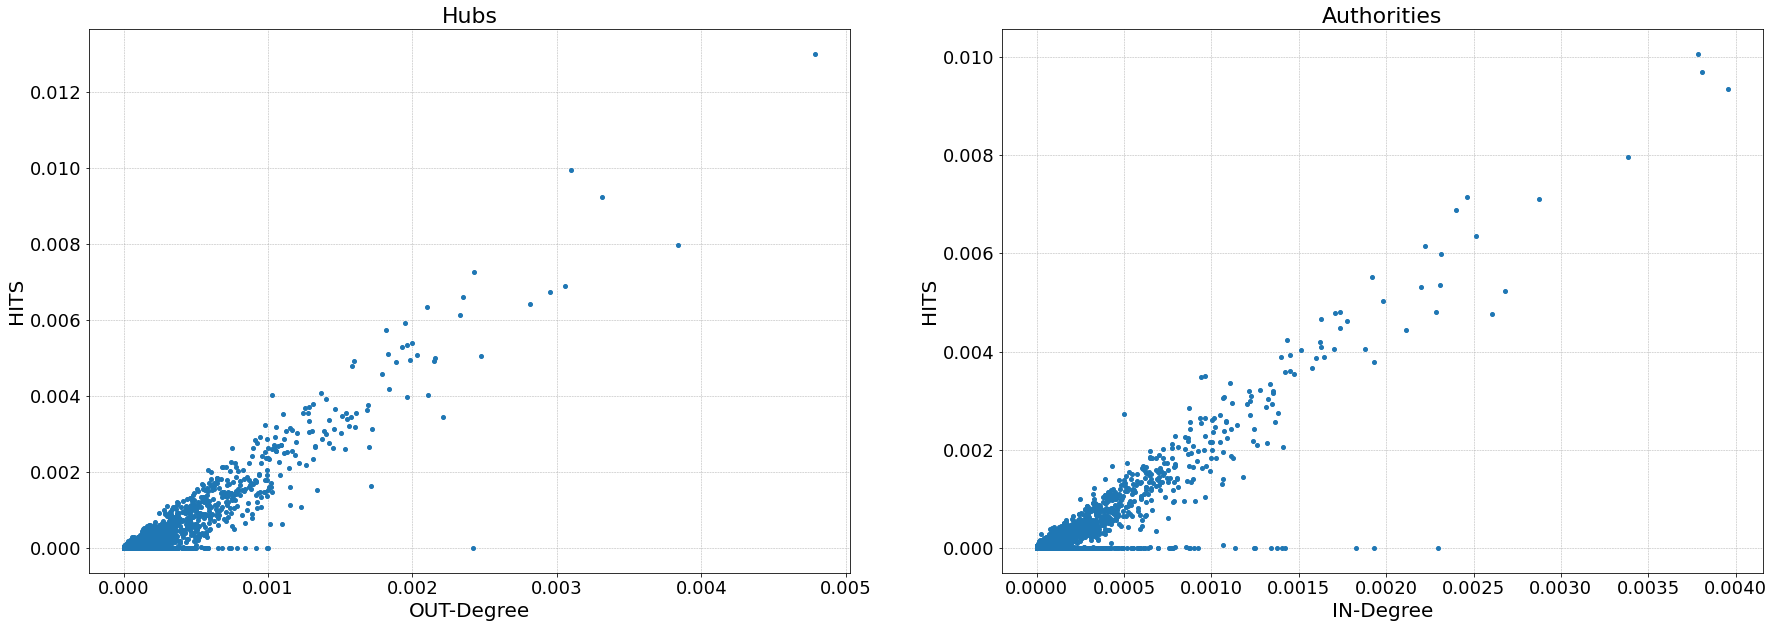

In [30]:
d_in = adj_matrix_crs.dot(np.ones(N)) 
d_out = (adj_matrix_crs.T).dot(np.ones(N))

fig, axs = plt.subplots(1, 2, figsize = (30, 10))

axs[0].plot(d_out/np.sum(d_out), np.array(list(hh.values())), 'o', markersize = 4)
axs[0].grid(which='both', linestyle='--', linewidth=0.5)
axs[0].set_title("Hubs", size = 22)
axs[0].set_xlabel("OUT-Degree", size = 20)
axs[0].set_ylabel("HITS", size = 20)
axs[0].tick_params(labelsize=18)
axs[0].tick_params(labelsize=18)


axs[1].plot(d_in/np.sum(d_in), np.array(list(aa.values())), 'o', markersize = 4)
axs[1].grid(which='both', linestyle='--', linewidth=0.5)
axs[1].set_title("Authorities", size = 22)
axs[1].set_xlabel("IN-Degree", size = 20)
axs[1].set_ylabel("HITS", size = 20)
axs[1].tick_params(labelsize=18)
axs[1].tick_params(labelsize=18)

plt.show()

### PageRank (NetworkX)

In [31]:
aa = nx.algorithms.link_analysis.pagerank_alg.pagerank(nx.DiGraph(adj_matrix_crs.T), tol = (1e-4)/len(nx.DiGraph(adj_matrix_crs.T)))
hh = nx.algorithms.link_analysis.pagerank_alg.pagerank(nx.DiGraph(adj_matrix_crs), tol = (1e-4)/len(nx.DiGraph(adj_matrix_crs.T)))

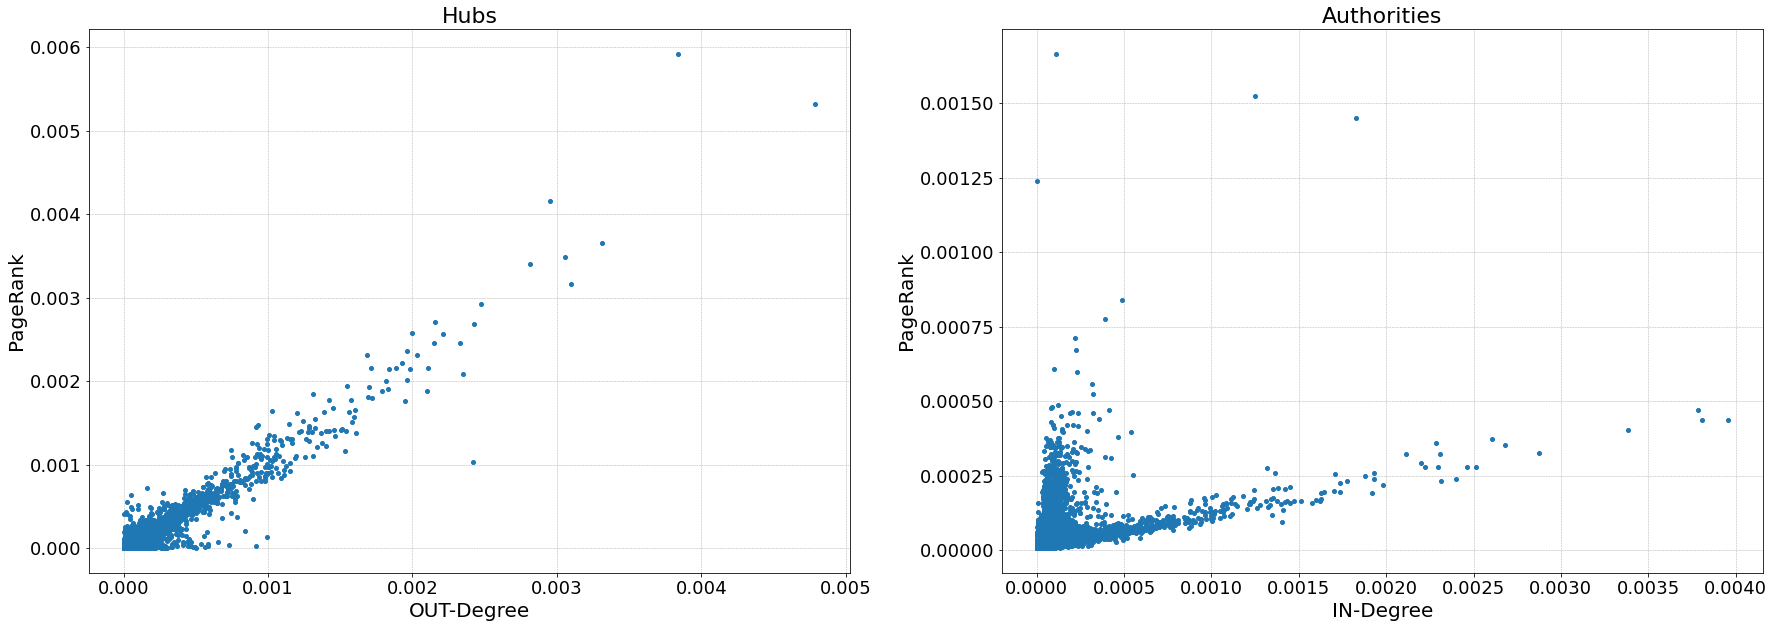

In [32]:
fig, axs = plt.subplots(1, 2, figsize = (30, 10))

axs[0].plot(d_out/np.sum(d_out), np.array(list(hh.values())), 'o', markersize = 4)
axs[0].grid(which='both', linestyle='--', linewidth=0.5)
axs[0].set_title("Hubs", size = 22)
axs[0].set_xlabel("OUT-Degree", size = 20)
axs[0].set_ylabel("PageRank", size = 20)
axs[0].tick_params(labelsize=18)
axs[0].tick_params(labelsize=18)


axs[1].plot(d_in/np.sum(d_in), np.array(list(aa.values())), 'o', markersize = 4)
axs[1].grid(which='both', linestyle='--', linewidth=0.5)
axs[1].set_title("Authorities", size = 22)
axs[1].set_xlabel("IN-Degree", size = 20)
axs[1].set_ylabel("PageRank", size = 20)
axs[1].tick_params(labelsize=18)
axs[1].tick_params(labelsize=18)

plt.show()

### Assortativity

In [33]:
from scipy import stats
from scipy.interpolate import interp1d as ipl
import math
import statistics as sts
import warnings

μ_in_in = 0.15638362290728472
μ_in_out = 0.20995903497413965
μ_out_in = 0.17916506276142283
μ_out_out = 0.24841968517033752


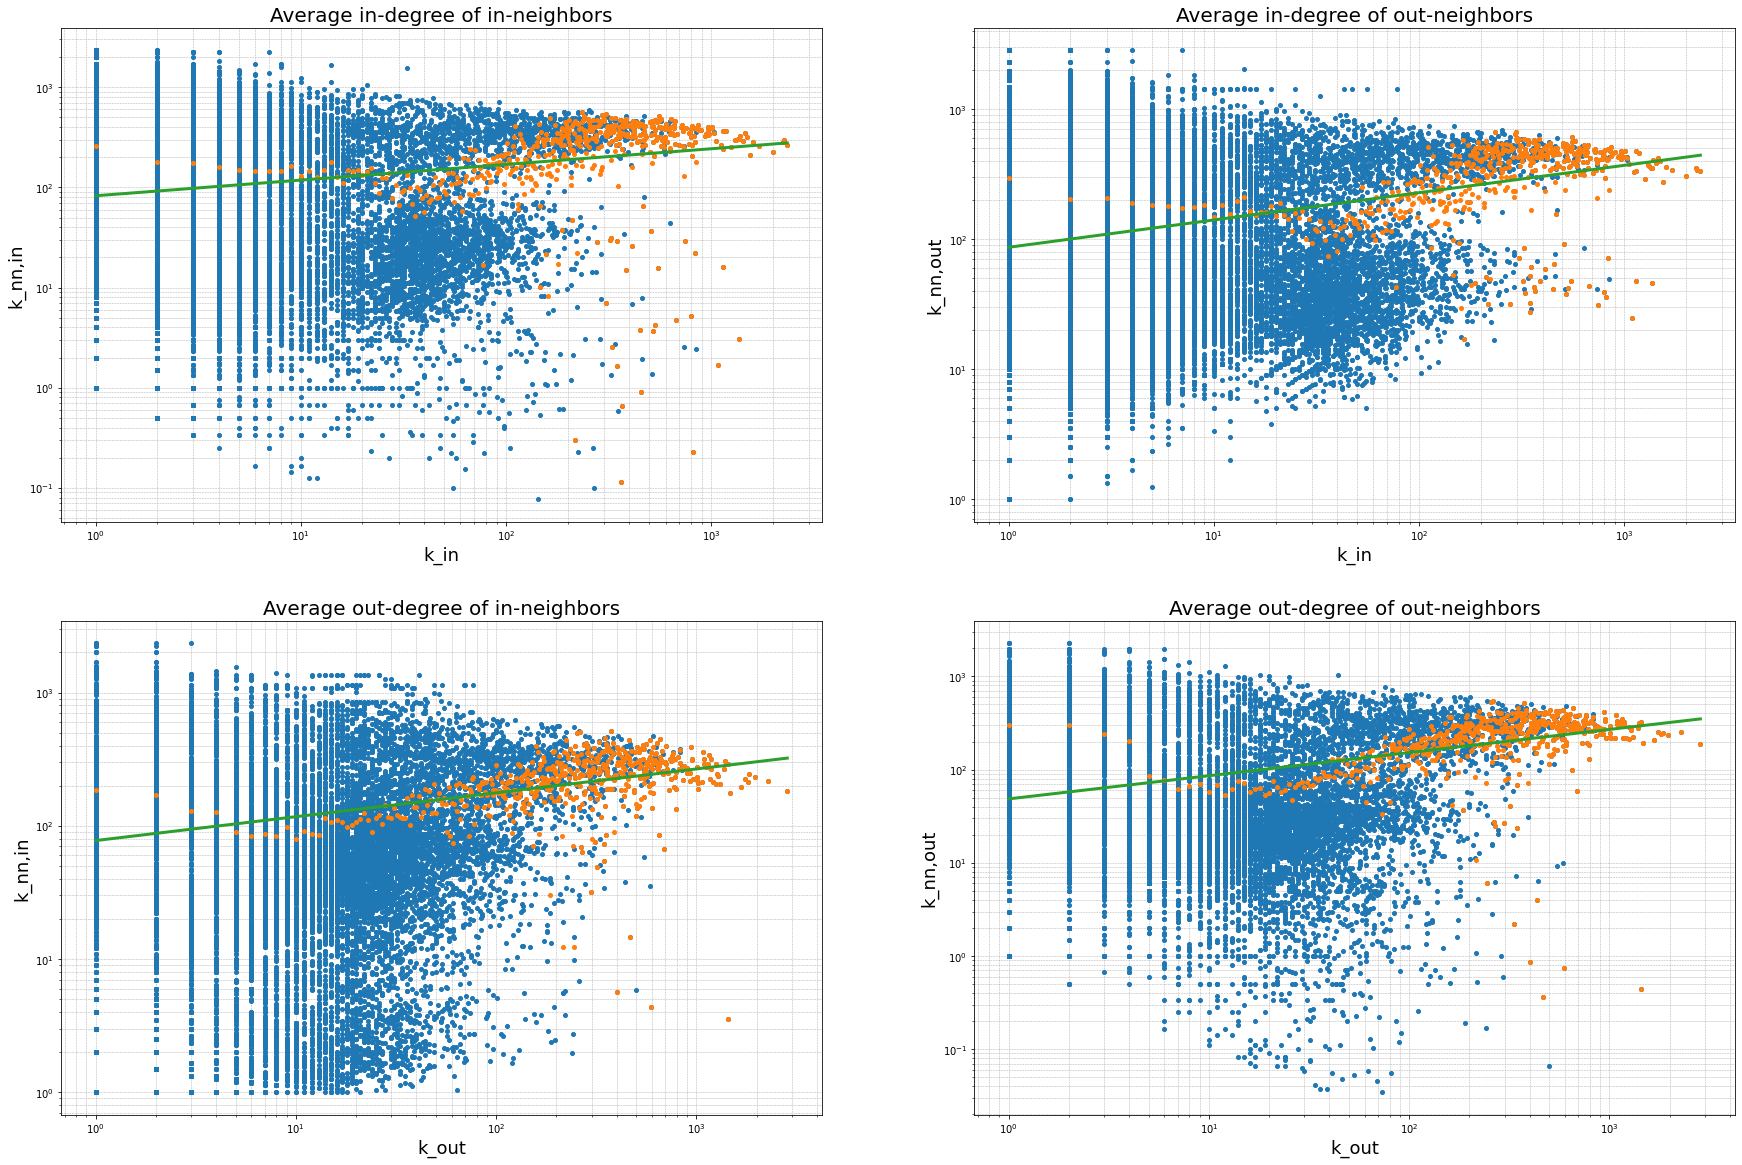

In [36]:
# calc average degree of neighbours
nonz = adj_matrix_crs.nonzero()
# sum of in_degree of in-neighbors
sum_in_in = np.zeros(N)
# sum of out_degree of in-neighbors
sum_out_in = np.zeros(N)
# sum of out_degree of out-neighbors
sum_out_out = np.zeros(N)
# sum of in_degree of out-neighbors
sum_in_out = np.zeros(N)

num_nei_in = np.zeros(N)
num_nei_out = np.zeros(N)
for row, column in zip(nonz[0], nonz[1]):
    num_nei_out[column] += 1
    num_nei_in[row] += 1
    sum_out_out[column] += d_out[row]
    sum_in_out[row] += d_out[column]
    sum_in_in[row] += d_in[column]
    sum_out_in[column] += d_in[row]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    avg_in_in = np.divide(sum_in_in, num_nei_in)
    avg_in_out = np.divide(sum_in_out, num_nei_in)
    avg_out_in = np.divide(sum_out_in, num_nei_out)
    avg_out_out = np.divide(sum_out_out, num_nei_out)

def find_mu(x,y):
    filter_x = ()
    filter_y = ()
    for a,b in zip(x,y):
        if (not math.isnan(b)) and a>0 and b>0:
            filter_x += (a,)
            filter_y += (b,)
    di = {}
    for x_ in filter_x:
        di[x_] = ()
    for x_, y_ in zip(filter_x, filter_y):
        di[x_] += (y_, )
    filter_x = ()
    filter_y = ()
    for key, value in di.items():
        filter_x += (key, )
        filter_y += (sts.mean(value),)
    num_log = list(map(lambda x : math.log(x, 10), filter_x))
    avg_log = list(map(lambda x : math.log(x, 10), filter_y))
    lin = stats.linregress(num_log, avg_log)
    inter_x = np.logspace(0, max(num_log),100)
    inter_y = inter_x**(lin.slope)*10**(lin.intercept)
    return lin.slope, filter_x, filter_y, inter_x, inter_y

fig, axs = plt.subplots(2, 2, figsize = (30, 20))

slope, filter_x, filter_y, inter_x, inter_y = find_mu(d_in, avg_in_in)
print("\u03BC_in_in =", slope)

axs[0,0].loglog(d_in, avg_in_in, 'o', markersize = 4)
axs[0,0].loglog(filter_x, filter_y, 'o', markersize = 4)
axs[0,0].plot(inter_x,inter_y,linewidth=3)
axs[0,0].grid(which='both', linestyle='--', linewidth=0.5)
axs[0,0].set_title("Average in-degree of in-neighbors", size = 20)
axs[0,0].set_xlabel("k_in", size = 18)
axs[0,0].set_ylabel("k_nn,in", size = 18)

slope, filter_x, filter_y, inter_x, inter_y = find_mu(d_in, avg_in_out)
print("\u03BC_in_out =", slope)

axs[0,1].loglog(d_in, avg_in_out, 'o', markersize = 4)
axs[0,1].loglog(filter_x, filter_y, 'o', markersize = 4)
axs[0,1].plot(inter_x,inter_y,linewidth=3)
axs[0,1].grid(which='both', linestyle='--', linewidth=0.5)
axs[0,1].set_title("Average in-degree of out-neighbors", size =20)
axs[0,1].set_xlabel("k_in", size = 18)
axs[0,1].set_ylabel("k_nn,out", size = 18)

slope, filter_x, filter_y, inter_x, inter_y = find_mu(d_out, avg_out_in)
print("\u03BC_out_in =", slope)

axs[1,0].loglog(d_out, avg_out_in, 'o', markersize = 4)
axs[1,0].loglog(filter_x, filter_y, 'o', markersize = 4)
axs[1,0].plot(inter_x,inter_y,linewidth=3)
axs[1,0].grid(which='both', linestyle='--', linewidth=0.5)
axs[1,0].set_title("Average out-degree of in-neighbors", size = 20)
axs[1,0].set_xlabel("k_out", size = 18)
axs[1,0].set_ylabel("k_nn,in", size = 18)

slope, filter_x, filter_y, inter_x, inter_y  = find_mu(d_out, avg_out_out)
print("\u03BC_out_out =", slope)

axs[1,1].loglog(d_out, avg_out_out, 'o', markersize = 4)
axs[1,1].loglog(filter_x, filter_y, 'o', markersize = 4)
axs[1,1].plot(inter_x,inter_y,linewidth=3)
axs[1,1].grid(which='both', linestyle='--', linewidth=0.5)
axs[1,1].set_title("Average out-degree of out-neighbors", size = 20)
axs[1,1].set_xlabel("k_out", size = 18)
axs[1,1].set_ylabel("k_nn,out", size = 18)
plt.show()

In [ ]:
l = len(df.index)-1
for i, (index, row) in enumerate(mobility_serie.iterrows()):
    adj_matrix_crs[node_position[index[1]],node_position[index[0]]] = row[0]
    adj_matrix_csc[node_position[index[1]],node_position[index[0]]] = row[0]
    if(i%1000==0):
        progressBar(i, l)
progressBar(l, l)
sparse.save_npz('adj_crs', adj_matrix_crs)
sparse.save_npz('adj_csc', adj_matrix_csc)


In [ ]:
adj_matrix_crs= sparse.load_npz('adj_crs.npz')
adj_matrix_csc= sparse.load_npz('adj_csc.npz')


In [ ]:
df.groupby('Field of Education').ngroups

In [ ]:
print((mobility_serie))